# Movie recommender system
1. matrix factorization
2. multilayer perceptron

**dataset:** ml-100k

In [1]:
from sklearn.datasets import dump_svmlight_file
import numpy as np
import pandas as pd
import os
import urllib
import zipfile
from sklearn.model_selection import train_test_split
import shutil
 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
 
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam

## Load dataset

In [2]:
# legge il dataset
dataset = pd.read_csv("ml-100k/u.data", sep='\t', names="user_id,item_id,rating,timestamp".split(","))

In [3]:
# fa partire gli indici da 0 invece che da 1
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values

In [4]:
train, test = train_test_split(dataset, test_size=0.2)

In [5]:
# conta il numero di film e utenti unici
n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())
n_latent_factors = 10
print(f'Number of users: {n_users}      Number of movies: {n_movies}')

Number of users: 943      Number of movies: 1682


In [6]:
# vettore latente film
movie_input = keras.layers.Input(shape=(1,), name='item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='movie_embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='flatten_movie')(movie_embedding)

# vettore latente film
user_input = keras.layers.Input(shape=(1,),name='User')
user_vec = keras.layers.Flatten(name='flatten_user')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='user_embedding')(user_input))

# prodotto scalare
prod = keras.layers.dot([movie_vec, user_vec], axes=1,name='dot_product')
model = keras.Model([user_input, movie_input], prod)

In [7]:
# compila il modello monitorando mean absolute error (MAE) e mean squared error (MSE)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 10)        16830       item[0][0]                       
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        9440        User[0][0]                       
______________________________________________________________________________________________

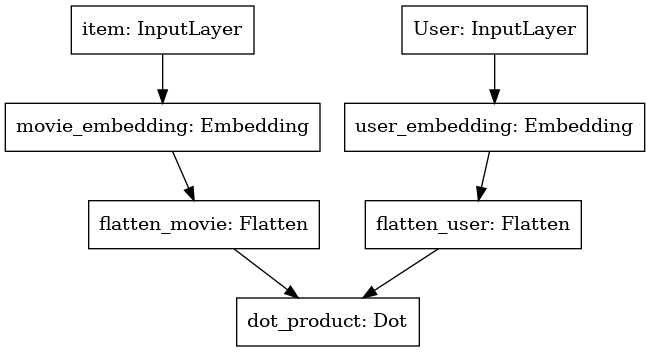

In [9]:
tf.keras.utils.plot_model(model)

In [10]:
# train del modello 
history = model.fit([train.user_id, train.item_id], train.rating, epochs=10, batch_size=128, verbose=1)

Epoch 1/10
625/625 [==============================] - 2s 3ms/step - loss: 13.0347 - mae: 3.4298 - mse: 13.0347
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 5.5416 - mae: 2.0403 - mse: 5.5416
Epoch 3/10
625/625 [==============================] - 1s 1ms/step - loss: 1.9383 - mae: 1.1038 - mse: 1.9383
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 1.2986 - mae: 0.8928 - mse: 1.2986
Epoch 5/10
625/625 [==============================] - 1s 2ms/step - loss: 1.0794 - mae: 0.8136 - mse: 1.0794
Epoch 6/10
625/625 [==============================] - 1s 1ms/step - loss: 0.9822 - mae: 0.7774 - mse: 0.9822
Epoch 7/10
625/625 [==============================] - 2s 3ms/step - loss: 0.9332 - mae: 0.7590 - mse: 0.9332
Epoch 8/10
625/625 [==============================] - 2s 3ms/step - loss: 0.9062 - mae: 0.7485 - mse: 0.9062
Epoch 9/10
625/625 [==============================] - 2s 3ms/step - loss: 0.8902 - mae: 0.7427 - mse: 0.8902
Epoch 10/10
625/6

Text(0, 0.5, 'Training Error')

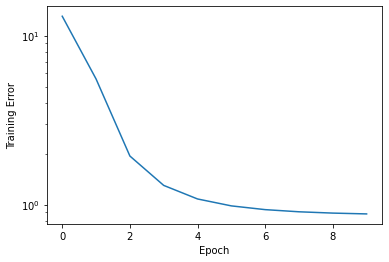

In [11]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")

In [12]:
results = model.evaluate((test.user_id, test.item_id), test.rating, batch_size=1)

20000/20000 [==============================] - 19s 957us/step - loss: 0.9323 - mae: 0.7598 - mse: 0.9323


In [13]:
# movie embedding
movie_embedding_learnt = model.get_layer(name='movie_embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt)

,0,1,2,3,4,5,6,7,8,9
0,-0.661850,0.688298,0.550016,0.642208,0.622743,-0.592722,0.653979,0.696544,0.719922,-0.605217
1,-0.571590,0.529897,0.549336,0.616262,0.468416,-0.499984,0.550699,0.531678,0.525230,-0.557184
2,-0.543155,0.581949,0.519830,0.579575,0.441633,-0.544025,0.466679,0.490135,0.552294,-0.495271
3,-0.601527,0.657107,0.546533,0.571101,0.529397,-0.608924,0.578836,0.627444,0.541740,-0.642895
4,-0.533683,0.526648,0.521911,0.531141,0.501947,-0.506489,0.503056,0.501307,0.565452,-0.531864
...,...,...,...,...,...,...,...,...,...,...
1678,-0.163874,0.196463,0.215077,0.178183,0.190934,-0.216903,0.257807,0.190887,0.197764,-0.199332
1679,0.021100,-0.042232,0.009979,-0.014002,-0.018506,0.007691,-0.004137,0.018022,-0.027739,-0.025066
1680,-0.133251,0.250786,0.218874,0.207853,0.132789,-0.213222,0.208867,0.206732,0.184930,-0.146350
1681,-0.197618,0.166497,0.221582,0.174180,0.241146,-0.215717,0.239595,0.180062,0.158522,-0.201743


In [15]:
# user embedding
user_embedding_learnt = model.get_layer(name='user_embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt)

,0,1,2,3,4,5,6,7,8,9
0,-0.611711,0.627048,0.634624,0.694858,0.609620,-0.568166,0.687920,0.567563,0.649526,-0.665944
1,-0.645251,0.647043,0.603852,0.639371,0.619357,-0.673145,0.641348,0.649831,0.697425,-0.627263
2,-0.499354,0.556897,0.475371,0.533103,0.507037,-0.443643,0.564400,0.557719,0.452940,-0.545915
3,-0.786618,0.788381,0.801090,0.702667,0.653803,-0.678501,0.720598,0.734149,0.821822,-0.711246
4,-0.521394,0.564132,0.575713,0.543320,0.499622,-0.469502,0.524230,0.520249,0.531506,-0.571056
...,...,...,...,...,...,...,...,...,...,...
939,-0.538166,0.535893,0.577541,0.563556,0.543194,-0.572764,0.550633,0.577170,0.567067,-0.596351
940,-0.698238,0.683848,0.662898,0.655037,0.593002,-0.653667,0.649121,0.586364,0.667670,-0.629653
941,-0.725941,0.625746,0.752207,0.660016,0.670338,-0.641197,0.732943,0.647906,0.660022,-0.657259
942,-0.563412,0.635222,0.601045,0.571778,0.573065,-0.582629,0.585062,0.631040,0.665515,-0.610530


### Predict top-k and rating

In [16]:

# migliori raccomandazione per un utente user_id
def recommend(user_id, number_of_movies=5):
    # prodotto tra la matrice user_embedding e la trasposta di movie_embedding, si ottengono i rating per l'utente user_id
    movies = user_embedding_learnt[user_id].dot(movie_embedding_learnt.T)

    # l'output di argpartition contiene la posizione che avrebbe un rating se fosse in una lista ordinata, prendendo i primi
    # n valori si ottengono gli id dei migliori film per l'utente.
    # movies_id può essere usato per trovare il rating nella lista dei film
    mids = np.argpartition(movies, -number_of_movies)[-number_of_movies:]
    return mids

# ritorna un df dei valori reali e predetti per un utente
def predict(user_id):
    df_actual_rating = test[(test['user_id'] == user_id)]
    predicted_rating_list = user_embedding_learnt[user_id].dot(movie_embedding_learnt.T)
    predicted_dict = {k:[] for k in ['item_id', 'actual_rating', 'pred_rating']}
    
    for index, row in df_actual_rating.iterrows():
        movie_id = row['item_id']
        actual_rating = row['rating']
        predicted_rating = predicted_rating_list[movie_id]

        predicted_dict['item_id'].append(movie_id)
        predicted_dict['actual_rating'].append(actual_rating)
        predicted_dict['pred_rating'].append(predicted_rating)
    
    df = pd.DataFrame(predicted_dict)

    return df


In [17]:
user = 377
movie = 800
n_movie_recommended = 10
recommended_id = recommend(user, n_movie_recommended)
recommended_id # lista film consigliati


array([479, 602, 133, 317, 113,  63, 177, 168, 482, 407])

In [18]:
predict(user).head(20) # df che contiene rating reali e rating predetti

,item_id,actual_rating,pred_rating
0,215,4,3.798611
1,4,3,3.085093
2,507,4,3.531724
3,297,3,3.620838
4,755,3,2.827781
5,325,3,3.310058
6,192,4,3.872886
7,722,3,3.099267
8,662,3,3.873980
9,1036,2,1.803223


In [19]:
# come trovare rating di un film
movies = user_embedding_learnt[user].dot(movie_embedding_learnt.T)
f"rating for movie {recommended_id[4]}: {movies[recommended_id[4]]}"

'rating for movie 113: 4.331613540649414'

In [20]:
# movie lookup dataframe
movie_lookup = pd.read_csv("ml-100k/u-utf8.item", sep='|', names="movie_id,movie_title".split(","), usecols=[0,1])
movie_lookup.movie_id = movie_lookup.movie_id.astype('category').cat.codes.values # indici da 0 invece che 1

In [21]:
movie_lookup

,movie_id,movie_title
0,0,Toy Story (1995)
1,1,GoldenEye (1995)
2,2,Four Rooms (1995)
3,3,Get Shorty (1995)
4,4,Copycat (1995)
...,...,...
1677,1677,Mat' i syn (1997)
1678,1678,B. Monkey (1998)
1679,1679,Sliding Doors (1998)
1680,1680,You So Crazy (1994)


In [22]:
# converte da id a nomi di film
recommended = movie_lookup[movie_lookup['movie_id'].isin(recommended_id)]
recommended

,movie_id,movie_title
63,63,"Shawshank Redemption, The (1994)"
113,113,Wallace & Gromit: The Best of Aardman Animatio...
133,133,Citizen Kane (1941)
168,168,"Wrong Trousers, The (1993)"
177,177,12 Angry Men (1957)
317,317,Schindler's List (1993)
407,407,"Close Shave, A (1995)"
479,479,North by Northwest (1959)
482,482,Casablanca (1942)
602,602,Rear Window (1954)


## MLP

In [23]:
movie_input = keras.layers.Input(shape=[1],name='item')

# Movie embedding
movie_embedding_mlp = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='movies_embedding')(movie_input)
movie_vec_mlp = keras.layers.Flatten(name='flatten_movies')(movie_embedding_mlp)

# User embedding
user_input = keras.layers.Input(shape=[1],name='user')
user_vec_mlp = keras.layers.Flatten(name='flatten_users')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='users_embedding')(user_input))

# Concat embedding utenti e film
concat = tf.keras.layers.Concatenate(name='users_movies')([movie_vec_mlp, user_vec_mlp])

# layers densi
dense = keras.layers.Dense(20,name='fully_connected_1')(concat)
dense_2 = keras.layers.Dense(10,name='fully_connected_2')(dense)

# Output
pred_mlp = keras.layers.Dense(1, activation='relu',name='Activation')(dense_2)

# crea e compila il modello
mlp = keras.Model([user_input, movie_input], pred_mlp)
mlp.compile(optimizer='adam',loss= 'mean_absolute_error', metrics=['mae', 'mse'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
movies_embedding (Embedding)    (None, 1, 10)        16830       item[0][0]                       
__________________________________________________________________________________________________
users_embedding (Embedding)     (None, 1, 10)        9440        user[0][0]                       
____________________________________________________________________________________________

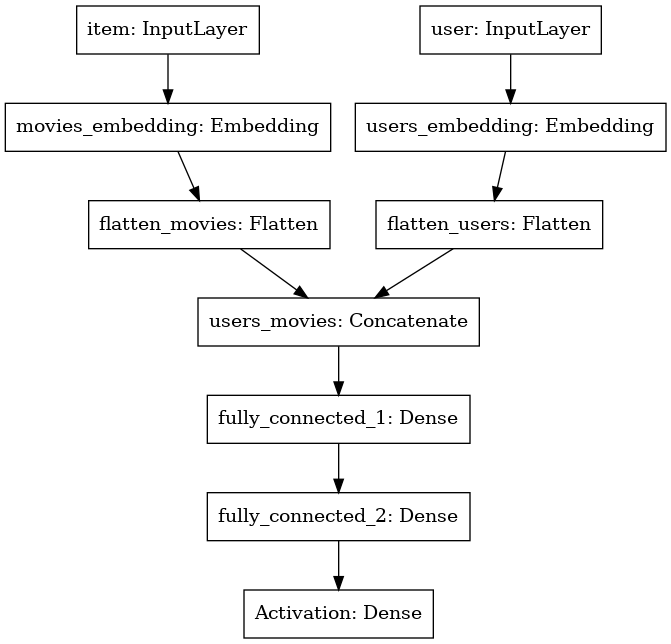

In [24]:
mlp.summary()
tf.keras.utils.plot_model(mlp)

In [29]:
history = mlp.fit([train.user_id, train.item_id], train.rating, epochs = 30, batch_size = 128, verbose = 1)

Epoch 1/30
625/625 [==============================] - 3s 6ms/step - loss: 0.7197 - mae: 0.7197 - mse: 0.8821
Epoch 2/30
625/625 [==============================] - 3s 5ms/step - loss: 0.7189 - mae: 0.7189 - mse: 0.8812
Epoch 3/30
625/625 [==============================] - 3s 5ms/step - loss: 0.7186 - mae: 0.7186 - mse: 0.8815
Epoch 4/30
625/625 [==============================] - 3s 4ms/step - loss: 0.7183 - mae: 0.7183 - mse: 0.8811
Epoch 5/30
625/625 [==============================] - 3s 4ms/step - loss: 0.7174 - mae: 0.7174 - mse: 0.8803
Epoch 6/30
625/625 [==============================] - 3s 4ms/step - loss: 0.7178 - mae: 0.7178 - mse: 0.8809
Epoch 7/30
625/625 [==============================] - 2s 4ms/step - loss: 0.7167 - mae: 0.7167 - mse: 0.8801
Epoch 8/30
625/625 [==============================] - 3s 4ms/step - loss: 0.7168 - mae: 0.7168 - mse: 0.8809
Epoch 9/30
625/625 [==============================] - 3s 4ms/step - loss: 0.7156 - mae: 0.7156 - mse: 0.8791
Epoch 10/30
625/625

In [30]:
 results_mlp = mlp.evaluate((test.user_id, test.item_id), test.rating, batch_size=1)

20000/20000 [==============================] - 42s 2ms/step - loss: 0.7473 - mae: 0.7473 - mse: 0.9495


In [31]:
# predizioni sul test set per un MLP
def predict_mlp():
    predicted_dict = {k:[] for k in ['user_id', 'item_id', 'actual_rating', 'pred_rating']}
    mlp_predicted = mlp.predict([test.user_id, test.item_id])
    test2 = test.reset_index(drop=True)

    for idx, row in test2.iterrows():
        predicted_dict['user_id'].append(row['user_id'])
        predicted_dict['item_id'].append(row['item_id'])
        predicted_dict['actual_rating'].append(row['rating'])
        predicted_dict['pred_rating'].append(mlp_predicted[idx][0])
        
    df = pd.DataFrame(predicted_dict)
    return df

In [32]:
predict_mlp()

,user_id,item_id,actual_rating,pred_rating
0,56,0,5,4.083109
1,42,271,5,4.469436
2,497,99,3,3.654265
3,454,123,4,4.127738
4,285,401,3,3.776524
...,...,...,...,...
19995,374,233,5,3.926463
19996,527,257,4,4.006219
19997,343,117,3,3.094669
19998,850,982,2,2.616165
